In [1]:
'''This script loads salary data, builds and test different predictive models.
Thereafter, it makes salary prediction on test data using the best model'''

'This script loads salary data, builds and test different predictive models.\nThereafter, it makes salary prediction on test data using the best model'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Functions

In [3]:
def load_file(file):
    '''load csv file to pd data frame'''
    return pd.read_csv(file)

def consolidate_data(df1, df2, key = None, left_index = False, right_index = False):
    '''perform inner join to return only records that are present in both dataframes'''
    return pd.merge (left = df1, right = df2, how = 'inner', on = key, left_index = left_index, right_index = right_index)

def clean_data(raw_df):
    '''remove data that have salary == 0 and duplicate job IDs'''
    clean_df = raw_df.drop_duplicates(subset = 'jobId')
    clean_df = clean_df[clean_df.salary > 0]
    return clean_df

def one_hot_encode_feature_df(df, cat_vars = None, num_vars = None):
    '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis = 1)     # ignore_index = False

def get_target_df(df, target):
    '''returns target dataframe'''
    return df[target]

def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv = 2, n_jobs = num_procs, scoring = 'neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')

In [4]:
#define inputs
train_feature_file = 'C:/Users/PC/Desktop/Salary pridiction/data/train_features.csv'
train_target_file = 'C:/Users/PC/Desktop/Salary pridiction/data/train_salaries.csv'
test_feature_file = 'C:/Users/PC/Desktop/Salary pridiction/data/test_features.csv'

#define variables
categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
numeric_vars = ['yearsExperience', 'milesFromMetropolis']
target_var = 'salary'

#load data
print("Loading data")
feature_df = load_file(train_feature_file)
target_df = load_file(train_target_file)
test_df = load_file(test_feature_file)

#consolidate training data
raw_train_df = consolidate_data(feature_df, target_df, key='jobId')

#clean, shuffle, and reindex training data -- shuffling improves cross-validation accuracy
clean_train_df = shuffle(clean_data(raw_train_df)).reset_index()

#encode categorical data and get final feature dfs
print("Encoding data")
feature_df = one_hot_encode_feature_df(clean_train_df, cat_vars = categorical_vars, num_vars = numeric_vars)
test_df = one_hot_encode_feature_df(test_df, cat_vars = categorical_vars, num_vars = numeric_vars)

#get target df
target_df = get_target_df(clean_train_df, target_var)

Loading data
Encoding data


In [5]:
#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}
res = {}

#define number of processes to run in parallel
num_procs = 2

#shared model paramaters
verbose_lvl = 0

In [6]:
#create models -- hyperparameter tuning already done by hand for each model
lr = LinearRegression()
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
rf = RandomForestRegressor(n_estimators = 150, n_jobs = num_procs, max_depth = 25, min_samples_split = 60, \
                           max_features = 30, verbose = verbose_lvl)
gbm = GradientBoostingRegressor(n_estimators = 150, max_depth = 5, loss = 'ls', verbose = verbose_lvl)
                      
models.extend([lr, lr_std_pca, rf, gbm])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation

Model:
 LinearRegression()
Average MSE:
 384.45106930859174
Standard deviation during CV:
 0.21378145979014107

Model:
 Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])
Average MSE:
 384.45457710309665
Standard deviation during CV:
 0.21053717230668667

Model:
 RandomForestRegressor(max_depth=25, max_features=30, min_samples_split=60,
                      n_estimators=150, n_jobs=2)
Average MSE:
 367.73726817189595
Standard deviation during CV:
 0.04361635931493879

Model:
 GradientBoostingRegressor(max_depth=5, n_estimators=150)
Average MSE:
 357.2948148118264
Standard deviation during CV:
 0.31321887136206783


In [7]:
#choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)

#train model on entire dataset
model.fit(feature_df, target_df)

#create predictions based on test data
predictions = model.predict(test_df)


Predictions calculated using model with lowest MSE:
GradientBoostingRegressor(max_depth=5, n_estimators=150)


In [8]:
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    #linear models don't have feature_importances_
    importances = [0]*len(feature_df.columns)
    
feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

#save results
save_results(model, mean_mse[model], predictions, feature_importances)

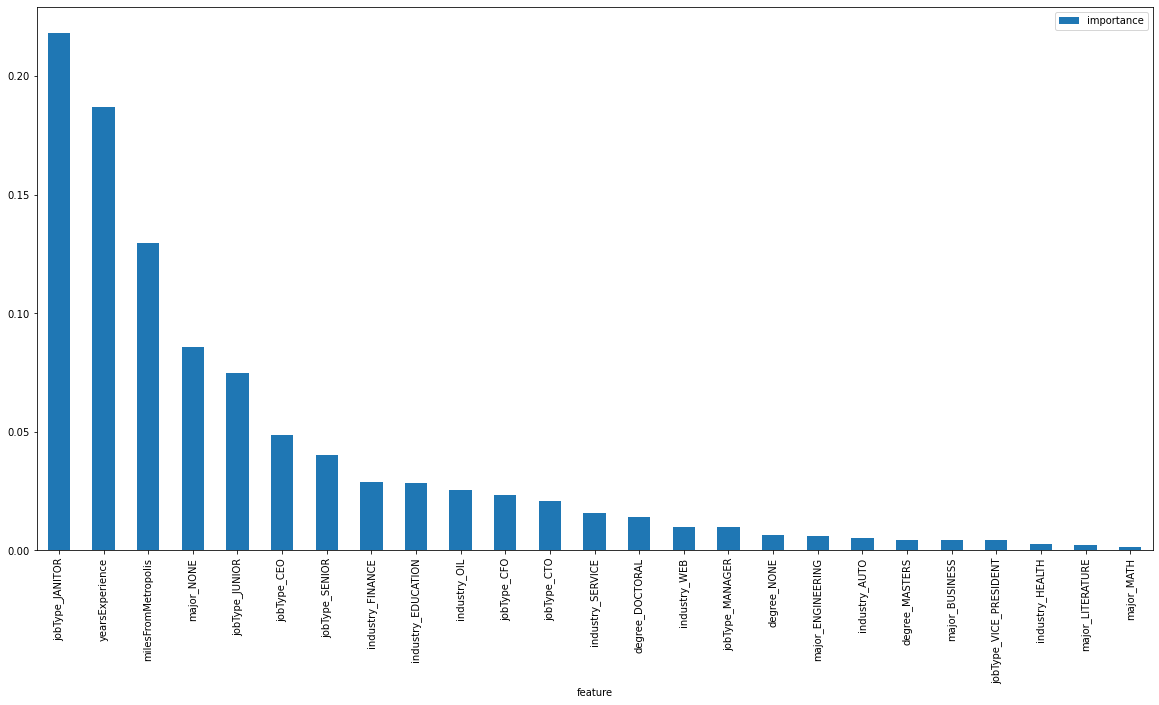

In [9]:
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

In [17]:
model

GradientBoostingRegressor(max_depth=5, n_estimators=150)

In [19]:
feature_importances.head(10)

,importance
feature,
jobType_JANITOR,0.218285
yearsExperience,0.186719
milesFromMetropolis,0.129771
major_NONE,0.085625
jobType_JUNIOR,0.074764
jobType_CEO,0.048494
jobType_SENIOR,0.040219
industry_FINANCE,0.028979
industry_EDUCATION,0.028569


In [23]:
pre = 'C:/Users/PC/Desktop/Salary pridiction/predictions.csv'
predictions_df = load_file(pre)
predictions_df.head(10)

,1.112319470299416508e+02
0,93.580768
1,178.931306
2,104.368652
3,117.074524
4,150.716434
5,96.429312
6,118.550027
7,106.949034
8,98.268421
9,80.163017
